<a href="https://colab.research.google.com/github/larasauser/master/blob/main/imgprep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 53.4 MB/s eta 0:00:00


In [ ]:
import os
import rasterio
import numpy as np

# Dossier contenant les images NDVI
folder_path = "/content/drive/MyDrive/NDVI_grancy_Landsat8_10"

# Compteurs
images_with_anomalies = 0
total_images = 0

print("Vérification des valeurs NDVI hors plage [-1, 1] :\n")

# Parcours des fichiers
for fname in os.listdir(folder_path):
    if fname.endswith(".tif"):
        image_path = os.path.join(folder_path, fname)
        total_images += 1

        with rasterio.open(image_path) as src:
            ndvi = src.read(1).astype(np.float32)

        # Masquer les NaN pour éviter des faux positifs
        ndvi_no_nan = ndvi[~np.isnan(ndvi)]

        # Vérification hors plage
        has_anomalies = np.any((ndvi_no_nan < -1.0) | (ndvi_no_nan > 1.0))
        ndvi_min = np.min(ndvi_no_nan)
        ndvi_max = np.max(ndvi_no_nan)

        if has_anomalies:
            images_with_anomalies += 1
            print(f"❌ {fname} → NDVI hors plage : min={ndvi_min:.3f}, max={ndvi_max:.3f}")
        else:
            print(f"✅ {fname} → OK : min={ndvi_min:.3f}, max={ndvi_max:.3f}")

# Résumé
print("\nRésumé :")
print(f"Images avec valeurs NDVI hors [-1, 1] : {images_with_anomalies}/{total_images}")


Vérification des valeurs NDVI hors plage [-1, 1] :

✅ NDVI_2013-04-18.tif → OK : min=0.024, max=0.705
✅ NDVI_2013-06-05.tif → OK : min=0.014, max=0.583
✅ NDVI_2013-11-12.tif → OK : min=-0.043, max=0.599
✅ NDVI_2013-07-07.tif → OK : min=0.031, max=0.589
✅ NDVI_2013-11-28.tif → OK : min=-0.010, max=0.997
✅ NDVI_2013-09-25.tif → OK : min=0.015, max=0.900
✅ NDVI_2013-12-30.tif → OK : min=-0.010, max=1.000
✅ NDVI_2014-01-15.tif → OK : min=0.115, max=0.639
✅ NDVI_2014-03-20.tif → OK : min=-0.032, max=0.711
✅ NDVI_2014-05-23.tif → OK : min=0.011, max=0.711
✅ NDVI_2014-09-12.tif → OK : min=0.019, max=0.593
✅ NDVI_2014-06-08.tif → OK : min=0.052, max=0.571
✅ NDVI_2014-10-14.tif → OK : min=-0.015, max=0.994
✅ NDVI_2014-09-28.tif → OK : min=0.029, max=0.598
✅ NDVI_2015-01-02.tif → OK : min=-0.080, max=0.997
✅ NDVI_2015-01-18.tif → OK : min=0.026, max=0.909
✅ NDVI_2015-03-23.tif → OK : min=-0.007, max=0.529
✅ NDVI_2015-04-08.tif → OK : min=0.021, max=0.499
✅ NDVI_2014-10-30.tif → OK : min=0.004, m

In [ ]:
import rasterio
import numpy as np

# Chemin vers ton image
image_path = '/content/drive/MyDrive/NDVI_grancy_Landsat8_10/NDVI_2013-10-18.tif'  # à adapter

with rasterio.open(image_path) as src:
    ndvi = src.read(1).astype(np.float32)

# 1. Min / Max brut
ndvi_min = np.nanmin(ndvi)
ndvi_max = np.nanmax(ndvi)

# 2. Anomalies hors NDVI
anomalies = (ndvi < -1.0) | (ndvi > 1.0)
num_anomalies = np.sum(anomalies)

# 3. Présence de NaN
num_nan = np.sum(np.isnan(ndvi))

# Résultats
print(f"Image analysée : {image_path}")
print(f"Valeur NDVI minimale (brute) : {ndvi_min}")
print(f"Valeur NDVI maximale (brute) : {ndvi_max}")
print(f"Nombre de pixels anormaux (hors [-1, 1]) : {num_anomalies}")
print(f"Nombre de pixels NaN : {num_nan}")


Image analysée : /content/drive/MyDrive/NDVI_grancy_Landsat8_10/NDVI_2013-10-18.tif
Valeur NDVI minimale (brute) : 0.017478791996836662
Valeur NDVI maximale (brute) : 0.5599645972251892
Nombre de pixels anormaux (hors [-1, 1]) : 0
Nombre de pixels NaN : 8787


In [ ]:
pip install --upgrade rasterio

In [ ]:
import os
import rasterio
import numpy as np
# La ligne suivante est nécessaire pour la manipulation des transformations géospatiales.
# Elle est incluse dans rasterio >= 1.0.
from rasterio.transform import Affine

def crop_to_valid_data(input_path, output_path):
    """
    Recadre une image GeoTIFF pour ne conserver que la zone contenant des données valides (non-NaN).

    Cette fonction détecte le rectangle englobant les pixels valides, recadre l'image
    selon ce rectangle et met à jour les métadonnées géospatiales pour que l'image
    reste correctement géoréférencée.

    Args:
        input_path (str): Chemin vers le fichier GeoTIFF d'entrée.
        output_path (str): Chemin où sauvegarder le fichier GeoTIFF recadré.
    """
    try:
        with rasterio.open(input_path) as src:
            # Lire la première bande de données
            band = src.read(1)

            # Créer un masque booléen : True pour les pixels valides (pas NaN)
            valid_mask = ~np.isnan(band)

            # Si l'image ne contient aucune donnée valide, on l'ignore
            if not np.any(valid_mask):
                print(f"  -> Fichier ignoré ({os.path.basename(input_path)}): aucune donnée valide trouvée.")
                return

            # Trouver les indices des lignes et colonnes des pixels valides
            rows, cols = np.where(valid_mask)

            # Déterminer les limites (bounding box) de la zone valide
            y_min, y_max = rows.min(), rows.max()
            x_min, x_max = cols.min(), cols.max()

            # --- Calcul de la nouvelle transformation géospatiale (CORRIGÉ) ---
            # On crée une transformation de translation qui correspond au décalage du coin supérieur gauche
            translation = Affine.translation(x_min, y_min)
            # On la combine avec la transformation originale pour obtenir la nouvelle
            out_transform = src.transform * translation

            # Mettre à jour la hauteur et la largeur
            out_height = y_max - y_min + 1
            out_width = x_max - x_min + 1

            # Recadrer le tableau de données numpy
            cropped_data = band[y_min : y_max + 1, x_min : x_max + 1]

            # Mettre à jour le profil (métadonnées) de l'image pour l'écriture
            profile = src.profile
            profile.update({
                'height': out_height,
                'width': out_width,
                'transform': out_transform,
                'nodata': np.nan  # Spécifier explicitement la valeur nodata
            })

            # Écrire le nouveau fichier GeoTIFF avec les données recadrées et le bon profil
            with rasterio.open(output_path, 'w', **profile) as dst:
                dst.write(cropped_data, 1)

            print(f"  -> Succès : {os.path.basename(output_path)} a été recadré et sauvegardé.")

    except Exception as e:
        print(f"  -> Erreur lors du traitement de {os.path.basename(input_path)}: {e}")

def batch_crop_to_valid_data(input_folder, output_folder):
    """
    Applique la fonction de recadrage à tous les fichiers .tif d'un dossier.
    """
    # Créer le dossier de sortie s'il n'existe pas
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"Dossier de sortie créé : {output_folder}")

    # Lister tous les fichiers dans le dossier d'entrée
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(".tif"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            print(f"\nTraitement de {filename}...")
            crop_to_valid_data(input_path, output_path)

# --- Point d'entrée du script ---
if __name__ == '__main__':
    # Définissez vos chemins de dossiers ici
    folder_path = "/content/drive/MyDrive/NDVI_grancy_Landsat8_10"
    output_folder_path = "/content/drive/MyDrive/NDVI_grancy_Landsat8_10/crop"

    # Lancer le traitement par lots
    batch_crop_to_valid_data(folder_path, output_folder_path)

    print("\nTraitement de toutes les images terminé !")

Dossier de sortie créé : /content/drive/MyDrive/NDVI_grancy_Landsat8_10/crop

Traitement de NDVI_2013-04-18.tif...
  -> Succès : NDVI_2013-04-18.tif a été recadré et sauvegardé.

Traitement de NDVI_2013-06-05.tif...
  -> Succès : NDVI_2013-06-05.tif a été recadré et sauvegardé.

Traitement de NDVI_2013-11-12.tif...
  -> Succès : NDVI_2013-11-12.tif a été recadré et sauvegardé.

Traitement de NDVI_2013-07-07.tif...
  -> Succès : NDVI_2013-07-07.tif a été recadré et sauvegardé.

Traitement de NDVI_2013-11-28.tif...
  -> Succès : NDVI_2013-11-28.tif a été recadré et sauvegardé.

Traitement de NDVI_2013-09-25.tif...
  -> Succès : NDVI_2013-09-25.tif a été recadré et sauvegardé.

Traitement de NDVI_2013-12-30.tif...
  -> Succès : NDVI_2013-12-30.tif a été recadré et sauvegardé.

Traitement de NDVI_2014-01-15.tif...
  -> Succès : NDVI_2014-01-15.tif a été recadré et sauvegardé.

Traitement de NDVI_2014-03-20.tif...
  -> Succès : NDVI_2014-03-20.tif a été recadré et sauvegardé.

Traitement de

✅ NDVI_2020-08-27.tif : 319x344 -> 319x342


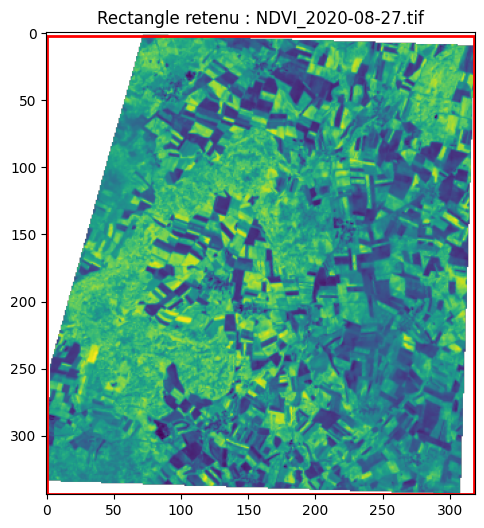

✅ NDVI_2020-05-07.tif : 319x344 -> 319x344


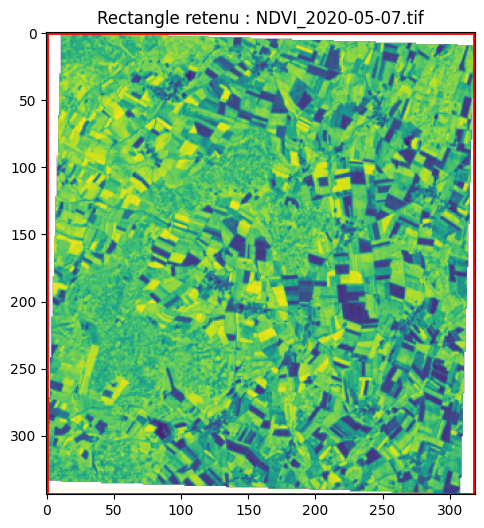

✅ NDVI_2014-08-18.tif : 322x347 -> 322x347


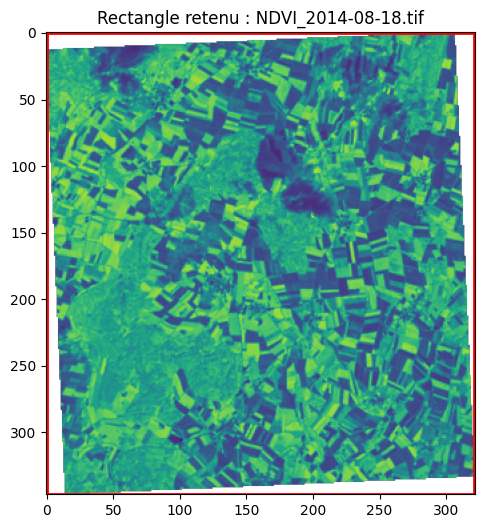

✅ NDVI_2019-10-03.tif : 322x347 -> 322x347
✅ NDVI_2020-01-16.tif : 319x344 -> 319x343
✅ NDVI_2022-11-21.tif : 319x344 -> 319x344
✅ NDVI_2023-04-14.tif : 319x344 -> 319x344
✅ NDVI_2014-03-20.tif : 319x344 -> 319x344
✅ NDVI_2016-08-16.tif : 319x344 -> 319x342
✅ NDVI_2014-10-14.tif : 319x344 -> 319x344
✅ NDVI_2023-02-25.tif : 319x344 -> 319x344
✅ NDVI_2021-06-18.tif : 322x347 -> 322x347
✅ NDVI_2022-01-12.tif : 322x347 -> 322x347
✅ NDVI_2013-05-27.tif : 322x347 -> 322x347
✅ NDVI_2022-02-13.tif : 322x347 -> 322x347
✅ NDVI_2013-08-31.tif : 322x347 -> 322x347
✅ NDVI_2016-06-29.tif : 319x344 -> 319x342
✅ NDVI_2021-01-18.tif : 319x344 -> 319x342
✅ NDVI_2023-06-17.tif : 319x344 -> 319x342
✅ NDVI_2014-09-12.tif : 319x344 -> 319x344
✅ NDVI_2013-12-05.tif : 322x347 -> 322x347
✅ NDVI_2023-02-09.tif : 319x344 -> 319x344
✅ NDVI_2020-07-01.tif : 322x347 -> 322x347
✅ NDVI_2020-04-05.tif : 319x344 -> 319x344
✅ NDVI_2018-09-30.tif : 322x347 -> 322x347
✅ NDVI_2014-05-23.tif : 319x344 -> 319x342
✅ NDVI_2021

In [22]:
import os
import random
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from rasterio.windows import Window

def crop_to_valid_rectangle(input_path, output_path, ndvi_min=-0.9, ndvi_max=1.0, visualize=False):
    """
    Recadre une image NDVI pour enlever les bords vides/blancs.
    Se base sur un masque NDVI compris entre [ndvi_min, ndvi_max].

    input_path : chemin vers l'image NDVI d'entrée
    output_path : chemin où sauvegarder l'image recadrée
    ndvi_min, ndvi_max : bornes NDVI valides
    visualize : affiche le rectangle retenu pour vérification
    """
    with rasterio.open(input_path) as src:
        band = src.read(1, masked=True)  # lecture avec masque
        arr = np.ma.filled(band, np.nan)  # remplace les nodata par NaN

        # masque NDVI valide
        valid = ~np.ma.getmaskarray(band)
        valid &= (arr >= ndvi_min) & (arr <= ndvi_max)

        if not valid.any():
            print(f"⚠️ {os.path.basename(input_path)} : aucune donnée valide")
            return

        # bounding box des pixels valides
        rows, cols = np.where(valid)
        y_min, y_max = rows.min(), rows.max()
        x_min, x_max = cols.min(), cols.max()

        # fenêtre de recadrage
        window = Window.from_slices((y_min, y_max + 1), (x_min, x_max + 1))
        cropped = src.read(window=window)
        out_transform = src.window_transform(window)

        profile = src.profile.copy()
        profile.update({
            "height": cropped.shape[1],
            "width": cropped.shape[2],
            "transform": out_transform
        })

        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        with rasterio.open(output_path, "w", **profile) as dst:
            dst.write(cropped)

        print(f"✅ {os.path.basename(input_path)} : {src.width}x{src.height} -> {cropped.shape[2]}x{cropped.shape[1]}")

        if visualize:
            fig, ax = plt.subplots(figsize=(6,6))
            ax.imshow(arr, cmap="viridis")
            rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min,
                                     linewidth=2, edgecolor="red", facecolor="none")
            ax.add_patch(rect)
            ax.set_title(f"Rectangle retenu : {os.path.basename(input_path)}")
            plt.show()


def batch_crop(folder_path, output_folder_path, ndvi_min=-0.9, ndvi_max=1.0, n_show=3):
    """
    Applique crop_to_valid_rectangle à toutes les images d'un dossier.
    n_show : nombre d'images affichées aléatoirement pour contrôle.
    """
    tif_files = [f for f in os.listdir(folder_path) if f.endswith(".tif")]
    random.shuffle(tif_files)
    show_subset = set(tif_files[:n_show])

    for file in tif_files:
        in_path = os.path.join(folder_path, file)
        out_path = os.path.join(output_folder_path, file)
        crop_to_valid_rectangle(in_path, out_path,
                                ndvi_min=ndvi_min, ndvi_max=ndvi_max,
                                visualize=(file in show_subset))


# ------------------------
# 🔹 Exemple d'utilisation
# ------------------------
folder_path = "/content/drive/MyDrive/NDVI_grancy_Landsat8_10"
output_folder_path = os.path.join(folder_path, "crop")

batch_crop(folder_path, output_folder_path, ndvi_min=-1, ndvi_max=1.0, n_show=3)



Affichage de la paire pour l'image : NDVI_2022-09-18.tif


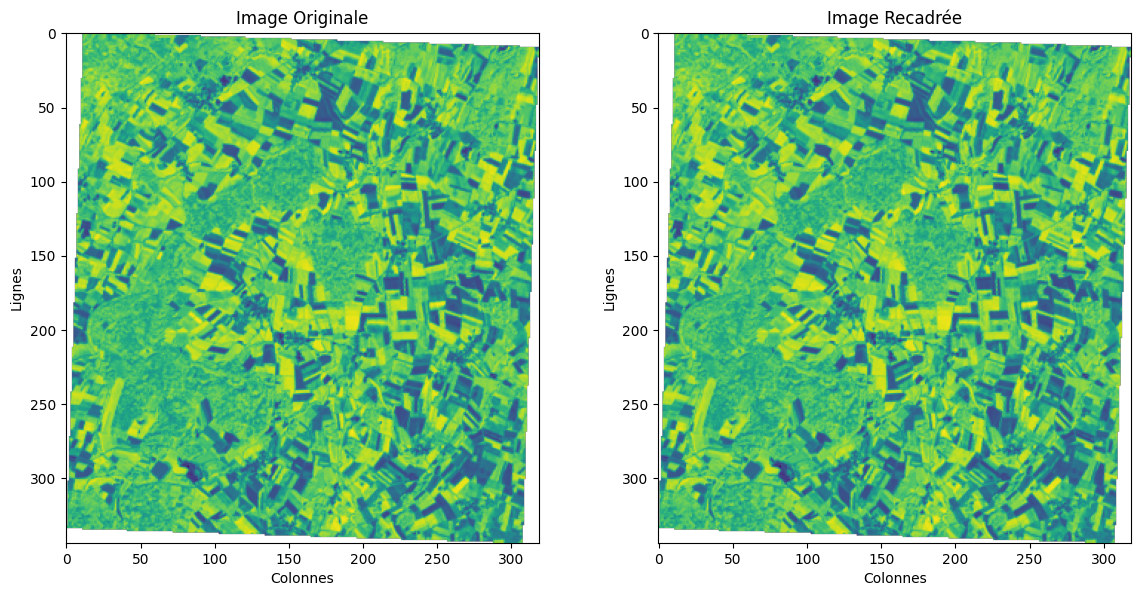


Affichage de la paire pour l'image : NDVI_2017-09-20.tif


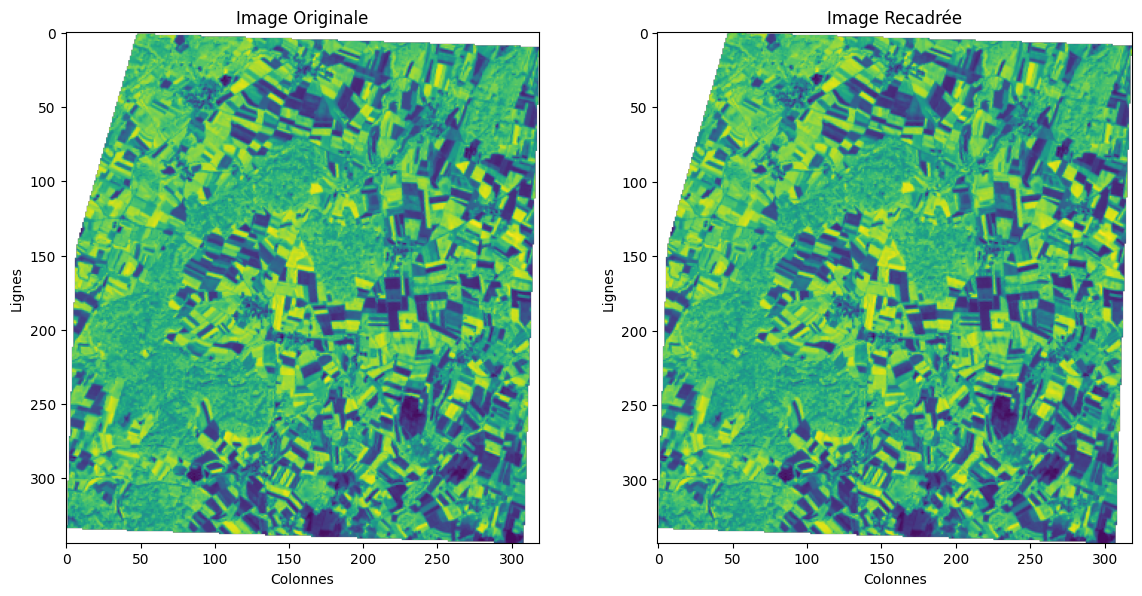

In [18]:
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import random

def display_random_pairs(original_folder, cropped_folder, num_pairs=2):
    """
    Affiche des paires d'images originales et recadrées sélectionnées aléatoirement.

    Args:
        original_folder (str): Chemin du dossier contenant les images originales.
        cropped_folder (str): Chemin du dossier contenant les images recadrées.
        num_pairs (int): Nombre de paires d'images à afficher.
    """
    # Lister les fichiers dans le dossier recadré pour obtenir les noms de fichiers
    cropped_files = [f for f in os.listdir(cropped_folder) if f.endswith('.tif')]

    if not cropped_files:
        print("Aucun fichier .tif trouvé dans le dossier recadré.")
        return

    # S'assurer de ne pas demander plus de paires qu'il n'y en a de disponibles
    num_to_display = min(num_pairs, len(cropped_files))

    # Sélectionner aléatoirement les fichiers
    selected_files = random.sample(cropped_files, num_to_display)

    for filename in selected_files:
        original_path = os.path.join(original_folder, filename)
        cropped_path = os.path.join(cropped_folder, filename)

        if not os.path.exists(original_path) or not os.path.exists(cropped_path):
            print(f"La paire de fichiers pour {filename} n'existe pas. Skipping.")
            continue

        print(f"\nAffichage de la paire pour l'image : {filename}")

        # Lire les images
        with rasterio.open(original_path) as src_orig, rasterio.open(cropped_path) as src_crop:
            orig_data = src_orig.read(1, masked=True)
            crop_data = src_crop.read(1, masked=True)

            # Créer la figure pour l'affichage
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))

            # Afficher l'image originale
            ax1 = axes[0]
            ax1.imshow(orig_data, cmap='viridis')
            ax1.set_title("Image Originale")
            ax1.set_xlabel("Colonnes")
            ax1.set_ylabel("Lignes")

            # Afficher l'image recadrée
            ax2 = axes[1]
            ax2.imshow(crop_data, cmap='viridis')
            ax2.set_title("Image Recadrée")
            ax2.set_xlabel("Colonnes")
            ax2.set_ylabel("Lignes")

            plt.tight_layout()
            plt.show()

# Définis tes chemins de dossiers
original_folder = "/content/drive/MyDrive/NDVI_grancy_Landsat8_10"
cropped_folder = "/content/drive/MyDrive/NDVI_grancy_Landsat8_10/crop"

# Exécute la fonction pour afficher les paires
display_random_pairs(original_folder, cropped_folder)

Nombre d'images trouvées : 72
✅ Recadrage terminé pour toutes les images.


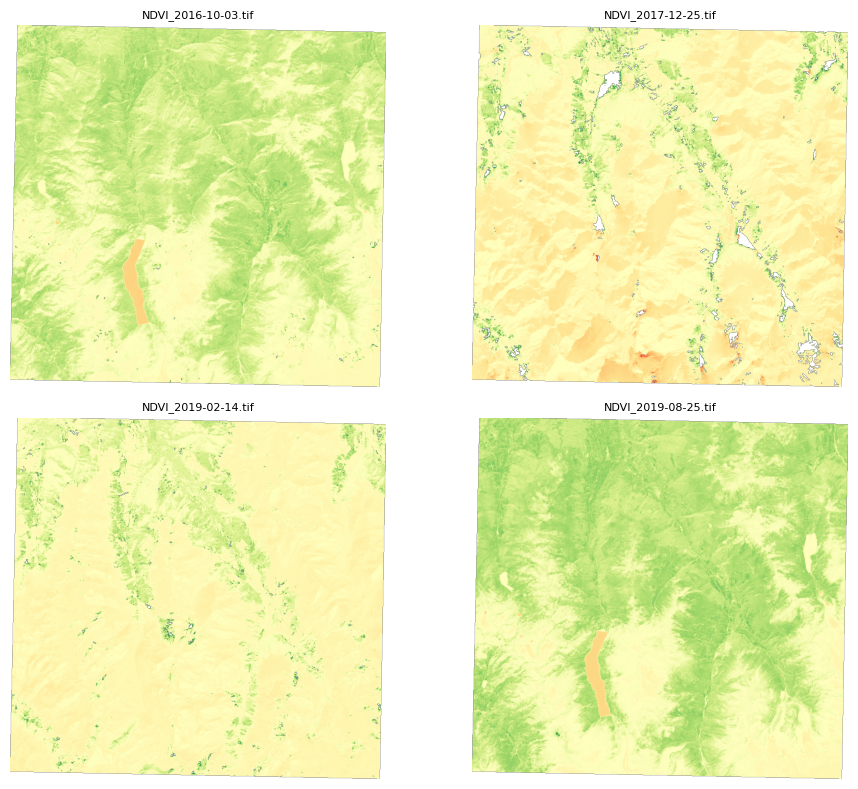

In [ ]:

#NONNONONNONON
import os
import glob
import random
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# 1. Chemins
input_folder = "/content/drive/MyDrive/NDVI_herens_Landsat8_10"
output_folder = "/content/drive/MyDrive/NDVI_herens_Landsat8_10/NDVI_herens_Landsat8_10_crop"

# 2. Créer le dossier de sortie s’il n’existe pas
os.makedirs(output_folder, exist_ok=True)

# 3. Récupérer toutes les images .tif
tif_files = sorted(glob.glob(os.path.join(input_folder, "*.tif")))

print(f"Nombre d'images trouvées : {len(tif_files)}")

def crop_ndvi_image(image_path, output_path):
    with rasterio.open(image_path) as src:
        ndvi = src.read(1).astype(np.float32)
        profile = src.profile

    # Masque des pixels valides NDVI
    valid_mask = (~np.isnan(ndvi)) & (ndvi >= -1.0) & (ndvi <= 1.0)

    if not np.any(valid_mask):
        print(f"Aucun pixel NDVI valide dans : {image_path}")
        return

    # Trouver les lignes/colonnes utiles
    rows = np.any(valid_mask, axis=1)
    cols = np.any(valid_mask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    # Recadrer l'image
    ndvi_cropped = ndvi[rmin:rmax+1, cmin:cmax+1]

    # Mettre à jour le profil (dimensions + fenêtre géo)
    transform = src.transform
    new_transform = rasterio.transform.from_origin(
        transform.c + cmin * transform.a,
        transform.f + rmin * transform.e,
        transform.a,
        transform.e
    )

    profile.update({
        'height': ndvi_cropped.shape[0],
        'width': ndvi_cropped.shape[1],
        'transform': new_transform
    })

    # Sauvegarder l'image recadrée
    with rasterio.open(output_path, "w", **profile) as dst:
        dst.write(ndvi_cropped, 1)

# 4. Appliquer à toutes les images
for tif_file in tif_files:
    filename = os.path.basename(tif_file)
    output_path = os.path.join(output_folder, filename)
    crop_ndvi_image(tif_file, output_path)

print("✅ Recadrage terminé pour toutes les images.")

# 5. Afficher 4 images recadrées aléatoires
sample_files = random.sample(glob.glob(os.path.join(output_folder, "*.tif")), 4)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for ax, img_path in zip(axes, sample_files):
    with rasterio.open(img_path) as src:
        ndvi = src.read(1)
    ax.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
    ax.set_title(os.path.basename(img_path), fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.impute import SimpleImputer
# Create folder with imputed images
folder_path = '/content/drive/MyDrive/NDVI_grancy_Landsat8_10/'
output_folder = os.path.join(folder_path, "imputed")
os.makedirs(output_folder, exist_ok=True)

# Imputation function
def impute_ndvi_image(image_path, output_path):
    with rasterio.open(image_path) as src:
        image = src.read(1)
        meta = src.meta

    # Mask NaN
    nan_mask = np.isnan(image)

    # Imputation of NaN with median
    imputer = SimpleImputer(strategy='median')
    image_imputed = imputer.fit_transform(image)

    # Save the image
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(image_imputed, 1)

# Loop over every file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".tif"):
        input_path = os.path.join(folder_path, filename)
        output_path = os.path.join(output_folder, filename)
        impute_ndvi_image(input_path, output_path)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWar

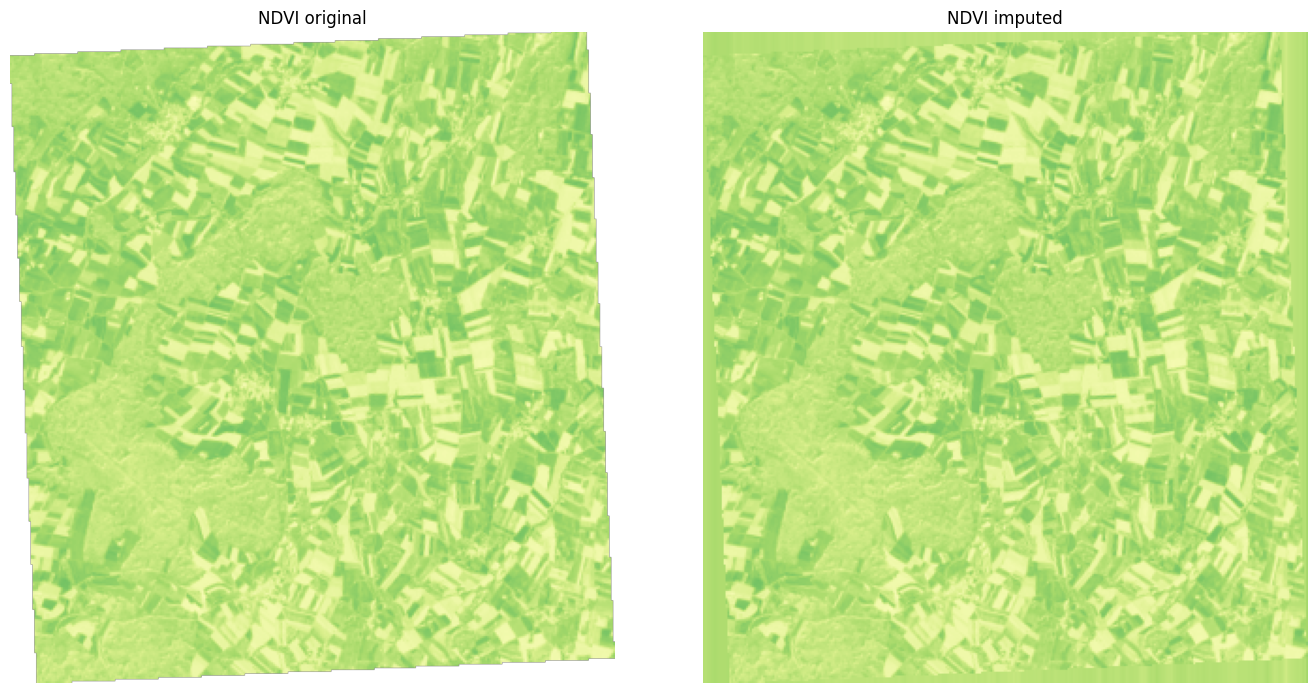

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

def read_ndvi(path):
    with rasterio.open(path) as src:
        ndvi = src.read(1).astype(np.float32)
        nodata = src.nodata
        #if nodata is not None:
            #ndvi = np.where(ndvi == nodata, np.nan, ndvi)
    return ndvi

# Chemins des images à comparer
path_full = '/content/drive/MyDrive/NDVI_grancy_Landsat8_10/NDVI_2013-10-18.tif'
path_with_holes = '/content/drive/MyDrive/NDVI_grancy_Landsat8_10/imputed/NDVI_2013-10-18.tif'

# Lire les images
ndvi_full = read_ndvi(path_full)
ndvi_holes = read_ndvi(path_with_holes)

# Affichage côte à côte
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

vmin, vmax = -1, 1  # plage NDVI classique

axes[0].imshow(ndvi_full, cmap='RdYlGn', vmin=vmin, vmax=vmax)
axes[0].set_title('NDVI original')
axes[0].axis('off')

axes[1].imshow(ndvi_holes, cmap='RdYlGn', vmin=vmin, vmax=vmax)
axes[1].set_title('NDVI imputed')
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os
import rasterio
import numpy as np
from glob import glob

def create_random_holes_nodata(img, min_size=25, max_size=75, max_holes=5, nodata_val=-9999):
    img_with_holes = img.copy()
    h, w = img.shape
    for _ in range(np.random.randint(1, max_holes + 1)):
        x = np.random.randint(0, w - max_size)
        y = np.random.randint(0, h - max_size)
        dx = np.random.randint(min_size, max_size + 1)
        dy = np.random.randint(min_size, max_size + 1)
        img_with_holes[y:y+dy, x:x+dx] = nodata_val
    return img_with_holes

input_dir = "/content/drive/MyDrive/NDVI_grancy_Landsat8_10/imputed"
output_dir = '/content/drive/MyDrive/NDVI_grancy_Landsat8_10/imputed/holes'
os.makedirs(output_dir, exist_ok=True)

image_paths = glob(os.path.join(input_dir, '*.tif'))
print(f"Nombre d'images à traiter : {len(image_paths)}")

success_count = 0
fail_count = 0

for path in image_paths:
    try:
        with rasterio.open(path) as src:
            img = src.read(1).astype(np.float32)
            profile = src.profile

        # Ajouter trous avec min_size et max_size
        img_with_holes = create_random_holes_nodata(img)

        # Mise à jour profil
        profile.update(
            dtype=rasterio.float32,
            nodata=profile.get('nodata', -9999),
            compress='lzw'
        )

        out_path = os.path.join(output_dir, os.path.basename(path))
        with rasterio.open(out_path, 'w', **profile) as dst:
            dst.write(img_with_holes, 1)

        print(f"✔ Image traitée et sauvegardée : {os.path.basename(path)}")
        success_count += 1

    except Exception as e:
        print(f"❌ Erreur sur {os.path.basename(path)} : {e}")
        fail_count += 1

print(f"\nTraitement terminé. {success_count} images traitées avec succès, {fail_count} erreurs.")


Nombre d'images à traiter : 249
✔ Image traitée et sauvegardée : NDVI_2021-10-24(1).tif
✔ Image traitée et sauvegardée : NDVI_2018-11-01.tif
✔ Image traitée et sauvegardée : NDVI_2020-01-07.tif
✔ Image traitée et sauvegardée : NDVI_2020-06-24.tif
✔ Image traitée et sauvegardée : NDVI_2023-01-31.tif
✔ Image traitée et sauvegardée : NDVI_2023-11-08.tif
✔ Image traitée et sauvegardée : NDVI_2021-02-26(1).tif
✔ Image traitée et sauvegardée : NDVI_2013-11-12.tif
✔ Image traitée et sauvegardée : NDVI_2015-04-08.tif
✔ Image traitée et sauvegardée : NDVI_2019-02-21.tif
✔ Image traitée et sauvegardée : NDVI_2020-02-24(1).tif
✔ Image traitée et sauvegardée : NDVI_2016-03-09.tif
✔ Image traitée et sauvegardée : NDVI_2013-08-31.tif
✔ Image traitée et sauvegardée : NDVI_2017-05-22.tif
✔ Image traitée et sauvegardée : NDVI_2023-01-24.tif
✔ Image traitée et sauvegardée : NDVI_2023-04-14.tif
✔ Image traitée et sauvegardée : NDVI_2023-04-05(1).tif
✔ Image traitée et sauvegardée : NDVI_2023-08-11(1).tif

In [ ]:
import rasterio

with rasterio.open('/content/drive/MyDrive/NDVI_grancy_Landsat8_10/NDVI_2013-10-18.tif') as src:
    width = src.width      # nombre de colonnes (pixels en X)
    height = src.height    # nombre de lignes (pixels en Y)
    print(f"Taille de l'image : {width} x {height} pixels")


Taille de l'image : 322 x 347 pixels


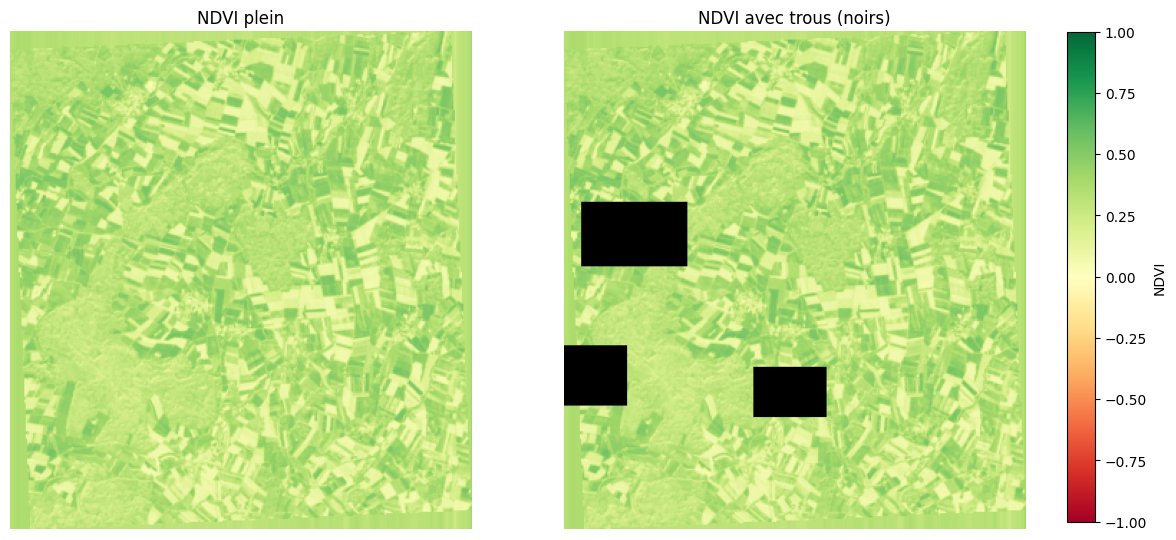

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def read_ndvi(path):
    with rasterio.open(path) as src:
        ndvi = src.read(1).astype(np.float32)
        nodata = src.nodata
        if nodata is not None:
            ndvi = np.where(ndvi == nodata, np.nan, ndvi)
    return ndvi

# Chemins des images à comparer
path_full = '/content/drive/MyDrive/NDVI_grancy_Landsat8_10/imputed/NDVI_2013-10-18.tif'
path_with_holes = '/content/drive/MyDrive/NDVI_grancy_Landsat8_10/imputed/holes/NDVI_2013-10-18.tif'

# Lire les images
ndvi_full = read_ndvi(path_full)
ndvi_holes = read_ndvi(path_with_holes)

# Supposons que ndvi_holes contient des NaN ou -99999
# On les masque pour les afficher en noir
masked_ndvi = np.ma.masked_where(np.isnan(ndvi_holes) | (ndvi_holes == -9999), ndvi_holes)

# Créer une copie de la colormap et définir les valeurs masquées en noir
cmap = plt.cm.RdYlGn.copy()
cmap.set_bad(color='black')  # couleur pour NaN ou valeurs masquées

vmin, vmax = -1, 1

# Affichage côte à côte
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Image NDVI plein
axes[0].imshow(ndvi_full, cmap='RdYlGn', vmin=vmin, vmax=vmax)
axes[0].set_title('NDVI plein')
axes[0].axis('off')

# Image NDVI avec trous (affichés en noir)
im1 = axes[1].imshow(masked_ndvi, cmap=cmap, vmin=vmin, vmax=vmax)
axes[1].set_title('NDVI avec trous (noirs)')
axes[1].axis('off')

# Colorbar à droite
plt.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(im1, cax=cbar_ax, label="NDVI")

plt.show()

